# Exploratory data analysis

## General introduction

Kaggle name: K Klustering Klan

- Simen Seeberg-Rommetveit -  543879
- Erik Hæstad Bjørnstad - 527739
- Mathias Haakon Aas - 527301

This is the long notebook containing these parts: 
- Data exploration 
- Feature engineering 
- Different models 
- Model interpratation

## Imports

In [30]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler



# Exploratory data analysis

In [31]:
data_parquet_file = "data/A/X_train_estimated.parquet"
data_parquet_file_observed = "data/A/X_train_observed.parquet"
target_parquet_file = "data/A/train_targets.parquet"


df_train_observed = pd.read_parquet(data_parquet_file_observed)
df_train_estimated = pd.read_parquet(data_parquet_file)
df_combined = pd.concat([df_train_observed, df_train_estimated])
df_target = pd.read_parquet(target_parquet_file) 
df_merged = pd.merge(df_combined, df_target, left_on="date_forecast", right_on="time", how="inner")

## Search domain knowledge

## Check if data is intuitive

### Plot features over time

### Check pv_measurements at night 

In [32]:
# Filter the DataFrame based on the conditions
pv_measurements_at_night = df_merged.loc[(df_merged["is_day:idx"] == 0) & (df_merged["pv_measurement"] != 0)]

# Print the shape of the filtered DataFrame
print(pv_measurements_at_night.shape)
print(pv_measurements_at_night["pv_measurement"].mean())


(1358, 49)
32.47114138438881


## Feature exploration

### Feature importance

In [33]:


def rank_features_by_correlation(data_parquet_file, target_parquet_file):
    # Load main dataset and target dataset
    df_data = pd.read_parquet(data_parquet_file).head(5000)
    df_target = pd.read_parquet(target_parquet_file)

    # Check if 'date_forecast' and 'time' columns exist in their respective DataFrames
    if 'date_forecast' not in df_data.columns or 'time' not in df_target.columns:
        raise ValueError("'date_forecast' or 'time' column not found in one or both datasets")

    # Merge the datasets based on 'date_forecast' and 'time'
    df_merged = pd.merge(df_data, df_target, left_on='date_forecast', right_on='time', how='inner')

    # Get the name of the target column (assuming it's the last column in df_target)
    target_column = df_target.columns[-1]

    # Check if target column exists in merged DataFrame
    if target_column not in df_merged.columns:
        raise ValueError(f"Target column '{target_column}' not found in merged dataset")

    # Calculate correlation of each feature with the target column
    correlation_scores = df_merged.drop(['date_forecast', 'time'], axis=1).corr()[target_column].drop(target_column)

    # Rank features based on the absolute value of their correlation scores
    ranked_features = correlation_scores.abs().sort_values(ascending=False)

    return ranked_features

# Usage example

ranked_features = rank_features_by_correlation(data_parquet_file, target_parquet_file)
print(ranked_features)


direct_rad:W                      0.754767
clear_sky_rad:W                   0.685952
diffuse_rad:W                     0.665438
direct_rad_1h:J                   0.661076
is_in_shadow:idx                  0.617804
clear_sky_energy_1h:J             0.612760
diffuse_rad_1h:J                  0.605134
is_day:idx                        0.569564
sun_elevation:d                   0.440104
ceiling_height_agl:m              0.228913
effective_cloud_cover:p           0.227951
visibility:m                      0.227326
total_cloud_cover:p               0.190475
air_density_2m:kgm3               0.147271
wind_speed_v_10m:ms               0.124835
dew_point_2m:K                    0.123936
wind_speed_u_10m:ms               0.122025
t_1000hPa:K                       0.120597
absolute_humidity_2m:gm3          0.112695
snow_water:kgm2                   0.097222
relative_humidity_1000hPa:p       0.096870
fresh_snow_24h:cm                 0.095611
cloud_base_agl:m                  0.084773
fresh_snow_

C:\Users\simen\AppData\Local\Temp\ipykernel_20136\198941100.py:21: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_scores = df_merged.drop(['date_forecast', 'time'], axis=1).corr()[target_column].drop(target_column)


### features vs pv_measurement

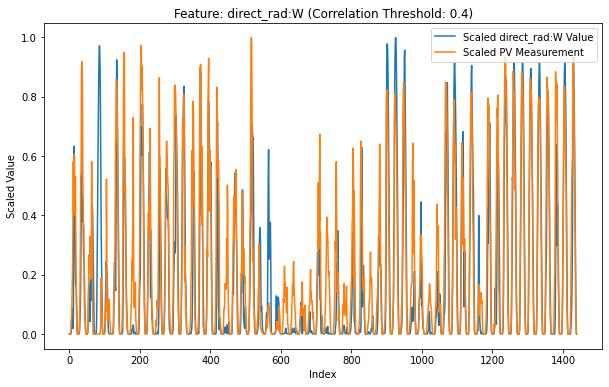

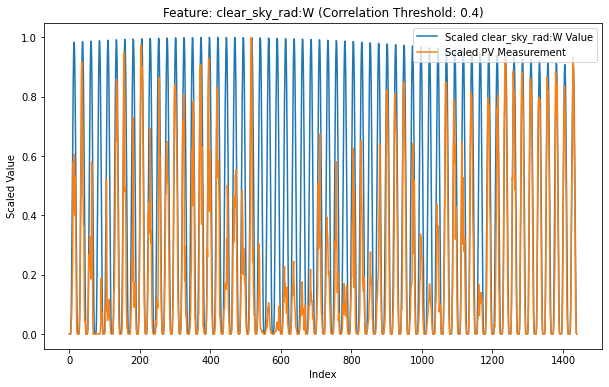

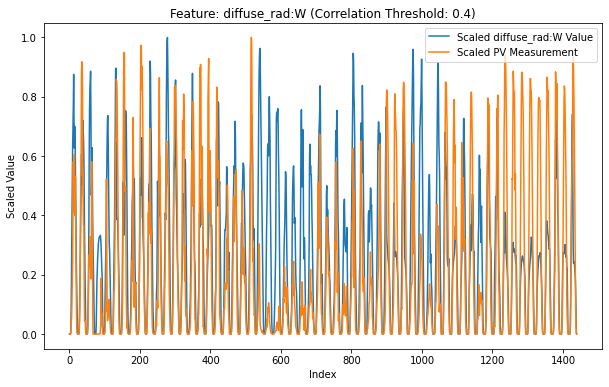

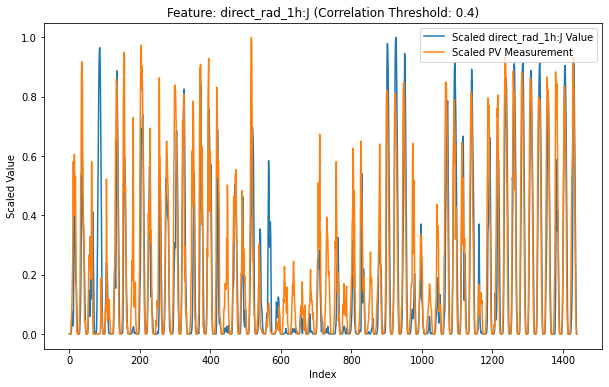

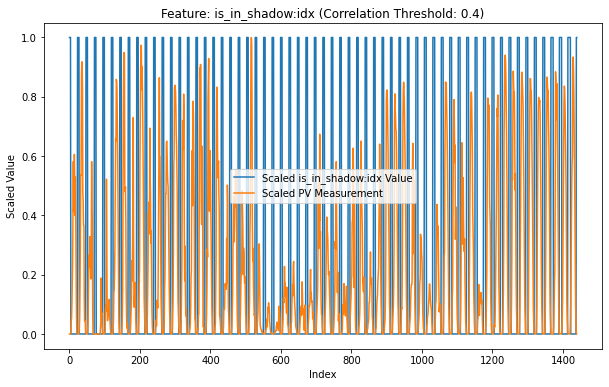

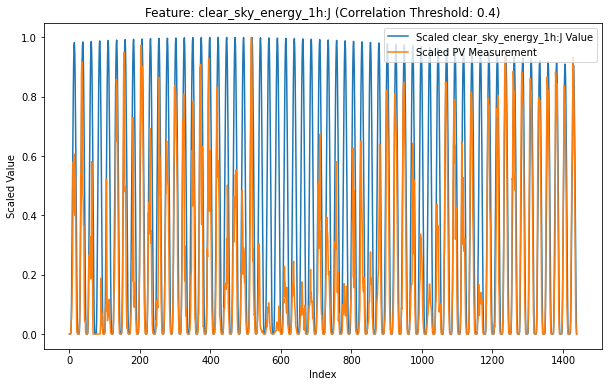

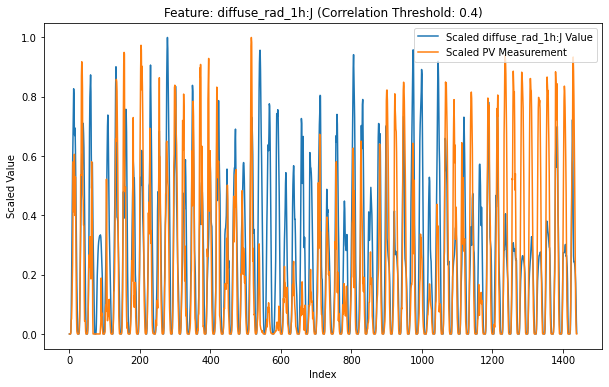

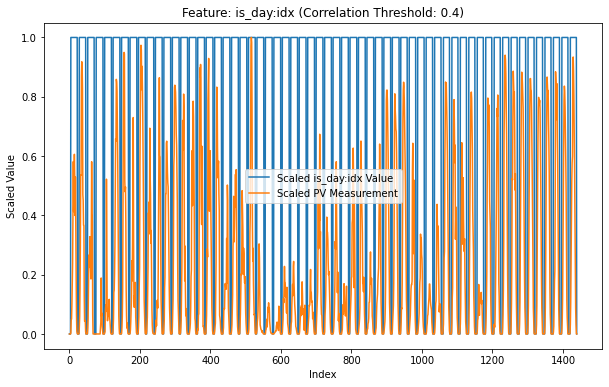

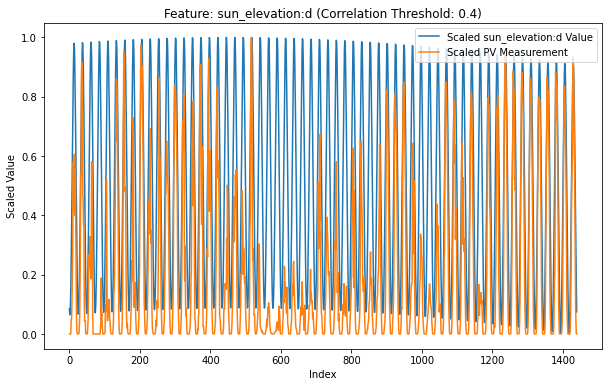

In [35]:
def plot_relevant_features(df, ranked_features, correlation_threshold=0.4, num_rows=1440):
    # Select the first 'num_rows' rows
    df_subset = df.head(num_rows)

    # Initialize a MinMaxScaler
    scaler = MinMaxScaler()

    # Filter the ranked features based on the correlation threshold
    relevant_features = ranked_features[ranked_features > correlation_threshold].index

    # Iterate over the relevant features
    for feature in relevant_features:
        if feature in df_subset.columns:
            # Scale the feature and pv_measurement values separately
            scaled_feature = scaler.fit_transform(df_subset[[feature]])
            scaled_pv_measurement = scaler.fit_transform(df_subset[['pv_measurement']])

            plt.figure(figsize=(10, 6))
            plt.plot(scaled_feature, label=f'Scaled {feature} Value')
            plt.plot(scaled_pv_measurement, label='Scaled PV Measurement')
            plt.title(f'Feature: {feature} (Correlation Threshold: {correlation_threshold})')
            plt.xlabel('Index')
            plt.ylabel('Scaled Value')
            plt.legend()
            plt.show()

# Usage example
plot_relevant_features(df_merged, ranked_features, correlation_threshold=0.4)


### Extended feature importance with data engineering

In [7]:

def manipulate_single_feature(df, feature_name):
    """
    Manipulate a single feature: 
    - Removing outliers
    - Applying log transformation (if all values are positive)
    - Returns a DataFrame with the manipulated feature and potential new features.
    """
    
    # 1. Outlier Removal
    low, high = np.percentile(df[feature_name], [3, 97])
    median = df[feature_name].median()
    df[feature_name + '_no_outliers'] = np.where(df[feature_name] < low, median, df[feature_name])
    df[feature_name + '_no_outliers'] = np.where(df[feature_name] > high, median, df[feature_name])
    
    # 2. Log Transformation
    if df[feature_name].min() > 0:
        df[feature_name + '_log'] = np.log(df[feature_name])

    return df


def rank_features_by_correlation(data_parquet_file, observed_parquet_file = None, target_parquet_file = None, threshold=None, num_features_to_keep=None):
    # Load main dataset, observed dataset and target dataset
    df_data = pd.read_parquet(data_parquet_file).head(5000)
    if observed_parquet_file is not None:
        df_observed = pd.read_parquet(observed_parquet_file).head(5000)
    
        # Concatenate the estimated and observed data vertically
        df_data = pd.concat([df_data, df_observed], axis=0, ignore_index=True)

    df_target = pd.read_parquet(target_parquet_file)

    # Check if 'date_forecast' and 'time' columns exist in their respective DataFrames
    if 'date_forecast' not in df_data.columns or 'time' not in df_target.columns:
        raise ValueError("'date_forecast' or 'time' column not found in one or both datasets")

    # Merge the datasets based on 'date_forecast' and 'time'
    df_merged = pd.merge(df_data, df_target, left_on='date_forecast', right_on='time', how='inner')

    # Feature Engineering

    # 1. Time-based Features
    df_merged['hour'] = df_merged['time'].dt.hour
    df_merged['month'] = df_merged['time'].dt.month
    df_merged['weekday'] = df_merged['time'].dt.weekday

    # Sinusoidal transformations for cyclical time features
    df_merged['hour_sin'] = np.sin(2 * np.pi * df_merged['hour'] / 24)
    df_merged['hour_cos'] = np.cos(2 * np.pi * df_merged['hour'] / 24)
    df_merged['month_sin'] = np.sin(2 * np.pi * df_merged['month'] / 12)
    df_merged['month_cos'] = np.cos(2 * np.pi * df_merged['month'] / 12)
    df_merged['weekday_sin'] = np.sin(2 * np.pi * df_merged['weekday'] / 7)
    df_merged['weekday_cos'] = np.cos(2 * np.pi * df_merged['weekday'] / 7)


    # 2. Interaction Features
    df_merged['snow_depth_radiation'] = df_merged['snow_depth:cm'] * df_merged['direct_rad:W']


    # 6. NaN Handling
    df_merged['snow_density:kgm3'].fillna(df_merged['snow_density:kgm3'].median(), inplace=True)
    df_merged['ceiling_height_agl:m'].fillna(df_merged['ceiling_height_agl:m'].median(), inplace=True)
    df_merged['cloud_base_agl:m'].fillna(df_merged['cloud_base_agl:m'].median(), inplace=True)

    # 7. Binning
    bins = [-90, 0, 45, 90]
    labels = ['Low', 'Medium', 'High']
    df_merged['sun_elevation_binned'] = pd.cut(df_merged['sun_elevation:d'], bins=bins, labels=labels, include_lowest=True)



    # 4. Derivative Features
    df_merged['rad_change'] = df_merged['direct_rad:W'].diff().fillna(0)
    # Similar calculations for other columns if deemed important.


    # One-hot encode 'sun_elevation_binned'
    df_merged = pd.get_dummies(df_merged, columns=['sun_elevation_binned'])

    # Drop Constant Features
    df_merged.drop(['elevation:m', 'snow_drift:idx', 'snow_melt_10min:mm', 'wind_speed_w_1000hPa:ms'], axis=1, inplace=True)
    df_merged = manipulate_single_feature(df_merged, 'clear_sky_rad:W')
    # Get the name of the target column (assuming it's the last column in df_target)
    target_column = df_target.columns[-1]
    
    # Calculate correlation of each feature with the target column
    correlation_scores = df_merged.drop(['date_forecast', 'time'], axis=1).corr()[target_column].drop(target_column)

    # Rank features based on the absolute value of their correlation scores
    ranked_features = correlation_scores.abs().sort_values(ascending=False)

    if threshold is not None:
        ranked_features = ranked_features[ranked_features > threshold]

    if num_features_to_keep is not None:
        ranked_features = ranked_features.head(num_features_to_keep)
    
    return ranked_features



# Usage example
data_parquet_file = "data/A/X_train_estimated.parquet"
observed_parquet_file = "data/A/X_train_observed.parquet"
target_parquet_file = "data/A/train_targets.parquet"

ranked_features = rank_features_by_correlation(data_parquet_file=data_parquet_file, observed_parquet_file=observed_parquet_file, target_parquet_file=target_parquet_file, threshold=0.1)
# ranked_features = rank_features_by_correlation(data_parquet_file, target_parquet_file=target_parquet_file, threshold=0.1)
ranked_features = rank_features_by_correlation(data_parquet_file, target_parquet_file=target_parquet_file, threshold=0.1)


print(ranked_features)



direct_rad:W                   0.754767
clear_sky_rad:W                0.685952
diffuse_rad:W                  0.665438
direct_rad_1h:J                0.661076
is_in_shadow:idx               0.617804
clear_sky_energy_1h:J          0.612760
diffuse_rad_1h:J               0.605134
is_day:idx                     0.569564
sun_elevation_binned_Medium    0.569564
sun_elevation_binned_Low       0.569564
clear_sky_rad:W_no_outliers    0.560152
sun_elevation:d                0.440104
rad_change                     0.428878
hour_cos                       0.395176
effective_cloud_cover:p        0.227951
visibility:m                   0.227326
date_calc                      0.203918
total_cloud_cover:p            0.190475
month_sin                      0.180140
month                          0.178678
hour_sin                       0.170814
month_cos                      0.155833
air_density_2m:kgm3            0.147271
ceiling_height_agl:m           0.129813
wind_speed_v_10m:ms            0.124835


### Feature engineering to new files

In [ ]:
import pandas as pd
import numpy as np

def generate_and_save_engineered_features(estimated_parquet_file=None, observed_parquet_file=None, target_parquet_file=None, output_parquet_file="engineered_data.parquet"):
    # Load main dataset, observed dataset, and target dataset
    df_estimated = pd.read_parquet(estimated_parquet_file)
    df_observed = pd.read_parquet(observed_parquet_file)

    df_target = pd.read_parquet(target_parquet_file)
    df_merged = pd.concat([df_observed, df_estimated], axis=0, ignore_index=True)
    print(df_merged.head())

    # Check if 'date_forecast' and 'time' columns exist in their respective DataFrames
    if 'date_forecast' not in df_merged.columns or 'time' not in df_target.columns:
        raise ValueError("'date_forecast' or 'time' column not found in one or both datasets")


    # Feature Engineering
    df_merged = feature_engineering(df_merged)

    # Save the engineered data
    df_merged.to_parquet(output_parquet_file)
    print(f"Engineered data saved to {output_parquet_file}")


def feature_engineering(df_merged):
    # Time-based Features
    df_merged['hour'] = df_merged['date_forecast'].dt.hour
    df_merged['month'] = df_merged['date_forecast'].dt.month
    df_merged['weekday'] = df_merged['date_forecast'].dt.weekday

    # Sinusoidal transformations for cyclical time features
    df_merged['hour_sin'] = np.sin(2 * np.pi * df_merged['hour'] / 24)
    df_merged['hour_cos'] = np.cos(2 * np.pi * df_merged['hour'] / 24)
    df_merged['month_sin'] = np.sin(2 * np.pi * df_merged['month'] / 12)
    df_merged['month_cos'] = np.cos(2 * np.pi * df_merged['month'] / 12)
    df_merged['weekday_sin'] = np.sin(2 * np.pi * df_merged['weekday'] / 7)
    df_merged['weekday_cos'] = np.cos(2 * np.pi * df_merged['weekday'] / 7)

    # Binning
    bins = [-90, 0, 45, 90]
    labels = ['1', '2', '3']
    df_merged['sun_elevation_binned'] = pd.cut(df_merged['sun_elevation:d'], bins=bins, labels=labels, include_lowest=True)


    return df_merged




# Usage example
estimated_parquet_file = "data/C/X_train_estimated.parquet"
observed_parquet_file = "data/C/X_train_observed.parquet"
target_parquet_file = "data/C/train_targets.parquet"
output_file = "cleaned_data/C/X_train_engineered.parquet"

generate_and_save_engineered_features(estimated_parquet_file=estimated_parquet_file, observed_parquet_file=observed_parquet_file, target_parquet_file=target_parquet_file, output_parquet_file=output_file)


## Clean up features

Throughout the notebook there are a variety of implemented techniques for data cleaning. Most notably are the following:
- Remove rows where pv_measurements are nan values
- Remove columns/features with many many nan values, or only identical values 
- Tried to fill, interpolate (linear and cubic) and drop nan values, except for in pv_measurement
- Remove outliers 
- Remove identical measurements, except for 0 values

# Models / Predictors

## Features to include and constants

In [ ]:
locations = ["A", "B", "C"]
features_order = []
A_B_ratio = 6.73
A_C_ratio = 8.17

LAGGED_COLUMNS_TO_KEEP = [
    'direct_rad:W_lag_1h', 
    'direct_rad:W_lag_forward_1h', 
    'clear_sky_rad:W_lag_1h', 
    'clear_sky_rad:W_lag_forward_1h', 
    'diffuse_rad:W_lag_1h', 
    'diffuse_rad:W_lag_forward_1h', 
    'direct_rad_1h:J_lag_1h', 
    'direct_rad_1h:J_lag_forward_1h', 
    'is_in_shadow:idx_lag_1h', 
    'is_in_shadow:idx_lag_forward_1h', 
    'clear_sky_energy_1h:J_lag_1h', 
    'clear_sky_energy_1h:J_lag_forward_1h', 
    'effective_cloud_cover:p_lag_1h', 
    'effective_cloud_cover:p_lag_forward_1h', 
    'visibility:m_lag_1h', 
    'visibility:m_lag_forward_1h', 
    'total_cloud_cover:p_lag_1h', 
    'total_cloud_cover:p_lag_forward_1h', 

    # Did not work well with lagged features >1h 
    
    # 'direct_rad:W_lag_2h', 
    # 'direct_rad:W_lag_forward_2h', 
    # 'clear_sky_rad:W_lag_2h', 
    # 'clear_sky_rad:W_lag_forward_2h', 
    # 'diffuse_rad:W_lag_2h', 
    # 'diffuse_rad:W_lag_forward_2h', 
    # 'direct_rad_1h:J_lag_2h', 
    # 'direct_rad_1h:J_lag_forward_2h', 
    # 'is_in_shadow:idx_lag_2h', 
    # 'is_in_shadow:idx_lag_forward_2h', 
    # 'clear_sky_energy_1h:J_lag_2h', 
    # 'clear_sky_energy_1h:J_lag_forward_2h', 
    # 'effective_cloud_cover:p_lag_2h', 
    # 'effective_cloud_cover:p_lag_forward_2h', 
    # 'visibility:m_lag_2h', 
    # 'visibility:m_lag_forward_2h', 
    # 'total_cloud_cover:p_lag_2h', 
    # 'total_cloud_cover:p_lag_forward_2h', 

    # 'direct_rad:W_lag_3h', 
    # 'direct_rad:W_lag_forward_3h', 
    # 'clear_sky_rad:W_lag_3h', 
    # 'clear_sky_rad:W_lag_forward_3h', 
    # 'diffuse_rad:W_lag_3h', 
    # 'diffuse_rad:W_lag_forward_3h', 
    # 'direct_rad_1h:J_lag_3h', 
    # 'direct_rad_1h:J_lag_forward_3h', 
    # 'is_in_shadow:idx_lag_3h', 
    # 'is_in_shadow:idx_lag_forward_3h', 
    # 'clear_sky_energy_1h:J_lag_3h', 
    # 'clear_sky_energy_1h:J_lag_forward_3h', 
    # 'effective_cloud_cover:p_lag_3h', 
    # 'effective_cloud_cover:p_lag_forward_3h', 
    # 'visibility:m_lag_3h', 
    # 'visibility:m_lag_forward_3h', 
    # 'total_cloud_cover:p_lag_3h', 
    # 'total_cloud_cover:p_lag_forward_3h'
]

CUSTOM_COLUMNS_TO_KEEP = [
    "hour_cos",
    "hour_sin",
    "month_sin",
    "month_cos",
    "hours_since_forecast",
]

WEATHER_FEATURES = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    "direct_rad_1h:J",
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "effective_cloud_cover:p",
    "visibility:m",
    "total_cloud_cover:p",
]


TEST_COLUMNS_TO_KEEP = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    "direct_rad_1h:J",
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "diffuse_rad_1h:J",
    "is_day:idx",
    "sun_elevation:d",
    "ceiling_height_agl:m",
    "effective_cloud_cover:p",
    "visibility:m",
    "total_cloud_cover:p",
    "air_density_2m:kgm3",
    "wind_speed_v_10m:ms",
    "dew_point_2m:K",
    "wind_speed_u_10m:ms",
    "t_1000hPa:K",
    "absolute_humidity_2m:gm3",
    "snow_water:kgm2",
    "relative_humidity_1000hPa:p",
    "fresh_snow_24h:cm",
    "cloud_base_agl:m",
    "fresh_snow_12h:cm",
    "snow_depth:cm",
    "dew_or_rime:idx",
    "fresh_snow_6h:cm",
    "super_cooled_liquid_water:kgm2",
    "fresh_snow_3h:cm",
    "rain_water:kgm2",
    "precip_type_5min:idx",
    "precip_5min:mm",
    "fresh_snow_1h:cm",
    "sun_azimuth:d",
    "msl_pressure:hPa",
    "pressure_100m:hPa",
    "pressure_50m:hPa",
    "sfc_pressure:hPa",
    "prob_rime:p",
    "wind_speed_10m:ms",
    "elevation:m",
    "snow_density:kgm3",
    "snow_drift:idx",
    "snow_melt_10min:mm",
    "wind_speed_w_1000hPa:ms",
    "observed_or_estimated",
    # "date_calc",
] + CUSTOM_COLUMNS_TO_KEEP  +  LAGGED_COLUMNS_TO_KEEP

COLUMNS_TO_KEEP = TEST_COLUMNS_TO_KEEP + ["pv_measurement"]



## Helper functions for data preprocessing

In [ ]:
def create_weather_lagged_features(df, weather_features):
    for feature in weather_features:
    
        # Creating lagged features for 1, 2 and 3 hours
        df[f'{feature}_lag_1h'] = df[feature].shift(1)
        # df[f'{feature}_lag_2h'] = df[feature].shift(2)
        # df[f'{feature}_lag_3h'] = df[feature].shift(3)

        df[f'{feature}_lag_forward_1h'] = df[feature].shift(-1)
        # df[f'{feature}_lag_forward_2h'] = df[feature].shift(-2)
        # df[f'{feature}_lag_forward_3h'] = df[feature].shift(-3)

    # Handling edges by filling NaNs with appropriate values
    df.fillna(method='ffill', inplace=True)  # Forward fill
    df.fillna(method='bfill', inplace=True)  # Backward fill
    
    return df


def create_lagged_features(df, column_name='pv_measurement'):
    # Deprecated because of jumps in dates to be predicted 

    df[f'{column_name}_prev_month'] = df[column_name].shift(24*7) # previous week
    df[f'{column_name}_prev_year'] = df[column_name].shift(24*365) # previous year
    df[f'{column_name}_2years_ago'] = df[column_name].shift(24*365*2) # next year


    df.fillna(method='ffill', inplace=True)  # Forward fill
    df.fillna(method='bfill', inplace=True)  # Backward fill

    return df

def add_custom_fields(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['date_forecast'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['date_forecast'].dt.hour / 24)

    df['month_sin'] = np.sin(2 * np.pi * df['date_forecast'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['date_forecast'].dt.month / 12)
    df['day-of-year'] = df['date_forecast'].dt.dayofyear
   
    return df

def add_calc_date(df_observed, df_estimated, df_test):
    # Function to calculate the difference in hours
    def calculate_hour_difference(row):
        diff = row['date_calc'] - row['date_forecast']
        return diff.total_seconds() / 3600  # Convert difference to hours

    # Apply the function to calculate the hour difference for df_estimated and df_test
    df_estimated['hours_since_forecast'] = df_estimated.apply(calculate_hour_difference, axis=1)
    df_test['hours_since_forecast'] = df_test.apply(calculate_hour_difference, axis=1)

    # Fill in zero for df_observed
    df_observed['hours_since_forecast'] = 0

    return df_observed, df_estimated, df_test


def remove_outliers(df):
    # Use a mask to filter out the rows where rolling std is zero but keep the rows where the value itself is zero
    mask = (df['pv_measurement'].rolling(5).std() == 0) & (df['pv_measurement'] != 0)
    df = df[~mask]
    return df

def resample_add_data(df, is_test_data):
    df = add_custom_fields(df)
    df.set_index('date_forecast', inplace=True)
    df = df.resample('1H').mean()
    
    # Remove empty dates if test data
    if is_test_data:
        non_nan_threshold = len(df.columns) // 2  
        df.dropna(thresh=non_nan_threshold, inplace=True)
    df.interpolate(method="linear", inplace=True)
    
    return df

def add_location_feature(X, location):
      # Treat location as a categorical feature by converting it to a category type
    
    # Tried to bin sun elevation, but had a negative impact
    # bins = [-90, 0, 45, 90]
    # labels = ['Low', 'Medium', 'High']
    # X['sun_elevation:d'] = pd.cut(X['sun_elevation:d'], bins=bins, labels=labels, include_lowest=True)

    X['location'] = location
    X['location'] = X['location'].astype(str)  # Convert to string if 'location' is not an int
    X['dew_or_rime:idx'] = X['dew_or_rime:idx'].astype(str)
    X['is_day:idx'] = X['is_day:idx'].astype(str)
    X['is_in_shadow:idx'] = X['is_in_shadow:idx'].astype(str)
    categorical_columns = ['location', 'dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx', 'sun_elevation:d']

    # Before filling NaN values, add 'missing' as a category for each categorical column.
    for column in categorical_columns:
        X[column] = X[column].astype('category')  # Ensure the column is of type 'category'.
        if 'missing' not in X[column].cat.categories:
            X[column] = X[column].cat.add_categories(['missing'])  # Add 'missing' as a new category.
        X[column] = X[column].fillna('missing')
    X['location'] = X['location'].astype('category')
    X['dew_or_rime:idx'] = X['dew_or_rime:idx'].astype('category')
    X['is_day:idx'] = X['is_day:idx'].astype('category')
    X['is_in_shadow:idx'] = X['is_in_shadow:idx'].astype('category')
    # X['sun_elevation:d'] = X['sun_elevation:d'].astype('category')
    
    return X

def add_scaling(X_test, X_training, location):
    global scalers
    continuous_columns = X_training.select_dtypes(include=['float32', 'int32']).columns
    if location not in scalers:
        scalers[location] = MinMaxScaler()
    X_training[continuous_columns] = scalers[location].fit_transform(X_training[continuous_columns])
    
    X_test[continuous_columns] = scalers[location].transform(X_test[continuous_columns])

    return X_test, X_training

def make_observed_and_estimated_category(df_observed, df_estimated, df_test):
    # Hot encode in wether observed or estimated
    df_observed['observed_or_estimated'] = 'observed'
    df_estimated['observed_or_estimated'] = 'estimated'
    df_test['observed_or_estimated'] = 'estimated'
    # Concatenate observed and estimated
    df_training = pd.concat([df_observed, df_estimated], axis=0).sort_values(by="date_forecast")
    df_training['observed_or_estimated'] = df_training['observed_or_estimated'].astype('category')
    df_test['observed_or_estimated'] = df_test['observed_or_estimated'].astype('category')

    return df_training, df_test

def analyze_pv_measurements(dataframe):
    # Filter the DataFrame for rows where 'is_day' is 0
    night_data = dataframe[dataframe['is_day:idx'] == 0]

    # Analysis of 'pv_measurements' during night time
    pv_stats = night_data['pv_measurement'].describe()

    return pv_stats


## Catboost model 

In [ ]:
def add_custom_fields(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['date_forecast'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['date_forecast'].dt.hour / 24)

    df['month_sin'] = np.sin(2 * np.pi * df['date_forecast'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['date_forecast'].dt.month / 12)
    df['day-of-year'] = df['date_forecast'].dt.dayofyear
   
    return df

def add_calc_date(df_observed, df_estimated, df_test):
    # Function to calculate the difference in hours
    def calculate_hour_difference(row):
        diff = row['date_calc'] - row['date_forecast']
        return diff.total_seconds() / 3600  # Convert difference to hours

    # Apply the function to calculate the hour difference for df_estimated and df_test
    df_estimated['hours_since_forecast'] = df_estimated.apply(calculate_hour_difference, axis=1)
    df_test['hours_since_forecast'] = df_test.apply(calculate_hour_difference, axis=1)

    # Fill in zero for df_observed
    df_observed['hours_since_forecast'] = 0

    return df_observed, df_estimated, df_test


def remove_outliers(df):
    # Use a mask to filter out the rows where rolling std is zero but keep the rows where the value itself is zero
    mask = (df['pv_measurement'].rolling(5).std() == 0) & (df['pv_measurement'] != 0)
    df = df[~mask]
    return df

def resample_add_data(df, is_test_data):
    df = add_custom_fields(df)
    df.set_index('date_forecast', inplace=True)
    df = df.resample('1H').mean()
    
    # Remove empty dates if test data
    if is_test_data:
        non_nan_threshold = len(df.columns) // 2  
        df.dropna(thresh=non_nan_threshold, inplace=True)
    df.interpolate(method="linear", inplace=True)
    
    return df

def add_location_feature(X, location):
      # Treat location as a categorical feature by converting it to a category type
    
    # bins = [-90, 0, 45, 90]
    # labels = ['Low', 'Medium', 'High']
    # X['sun_elevation:d'] = pd.cut(X['sun_elevation:d'], bins=bins, labels=labels, include_lowest=True)
    X['location'] = location
    X['location'] = X['location'].astype(str)  # Convert to string if 'location' is not an int
    X['dew_or_rime:idx'] = X['dew_or_rime:idx'].astype(str)
    X['is_day:idx'] = X['is_day:idx'].astype(str)
    X['is_in_shadow:idx'] = X['is_in_shadow:idx'].astype(str)
    categorical_columns = ['location', 'dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx', 'sun_elevation:d']

    # Before filling NaN values, add 'missing' as a category for each categorical column.
    for column in categorical_columns:
        X[column] = X[column].astype('category')  # Ensure the column is of type 'category'.
        if 'missing' not in X[column].cat.categories:
            X[column] = X[column].cat.add_categories(['missing'])  # Add 'missing' as a new category.
        X[column] = X[column].fillna('missing')
    X['location'] = X['location'].astype('category')
    X['dew_or_rime:idx'] = X['dew_or_rime:idx'].astype('category')
    X['is_day:idx'] = X['is_day:idx'].astype('category')
    X['is_in_shadow:idx'] = X['is_in_shadow:idx'].astype('category')
    # X['sun_elevation:d'] = X['sun_elevation:d'].astype('category')
    
    return X

def add_scaling(X_test, X_training, location):
    global scalers
    continuous_columns = X_training.select_dtypes(include=['float32', 'int32']).columns
    if location not in scalers:
        scalers[location] = MinMaxScaler()
    X_training[continuous_columns] = scalers[location].fit_transform(X_training[continuous_columns])
    
    X_test[continuous_columns] = scalers[location].transform(X_test[continuous_columns])

    return X_test, X_training

def make_observed_and_estimated_category(df_observed, df_estimated, df_test):
     # Hot encode in wether observed or estimated
    df_observed['observed_or_estimated'] = 'observed'
    df_estimated['observed_or_estimated'] = 'estimated'
    df_test['observed_or_estimated'] = 'estimated'
    # Concatenate observed and estimated
    df_training = pd.concat([df_observed, df_estimated], axis=0).sort_values(by="date_forecast")
    df_training['observed_or_estimated'] = df_training['observed_or_estimated'].astype('category')
    df_test['observed_or_estimated'] = df_test['observed_or_estimated'].astype('category')

    return df_training, df_test

def analyze_pv_measurements(dataframe):
    # Filter the DataFrame for rows where 'is_day' is 0
    night_data = dataframe[dataframe['is_day:idx'] == 0]

    # Analysis of 'pv_measurements' during night time
    pv_stats = night_data['pv_measurement'].describe()

    return pv_stats

    
    

## Catboost model 1

### Training

In [ ]:
def train_model(X_train, y_train, X_val, y_val, location):
    cat_features = [index for index, col in enumerate(X_train.columns) if col in ['location', 'dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx', 'observed_or_estimated']]
    
    model = CatBoostRegressor(
        iterations=6000,
        learning_rate=0.007,
        depth=12,  # assuming you decided to keep the depth reduced
        loss_function='MAE',
        verbose=200,
        cat_features=cat_features,
    )

    # Use the provided validation set for early stopping
    
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=False)
    model.save_model(f"catboost_model_merged.cbm")

def evaluate_model(X_val, y_val, location):
    global scaling_target  
    model = CatBoostRegressor()
    model.load_model(f"catboost_model_merged.cbm")
    
    # Unique locations in the X_val dataframe
    locations = X_val['location'].unique()
    
    for location in locations:
        # Filter X_val and y_val for the current location
        X_val_loc = X_val[X_val['location'] == location]
        y_val_loc = y_val[X_val['location'] == location]
        
        # Make predictions
        y_pred_loc = model.predict(X_val_loc)
        
        # Apply the transformation if needed (assuming y_val_loc and y_pred_loc are log1p transformed)
        # y_val_loc = np.expm1(y_val_loc)
        # y_pred_loc = np.expm1(y_pred_loc)
        
        # Calculate MAE for the current location
        mae = mean_absolute_error(y_val_loc, y_pred_loc)

        if scaling_target: 
            if location == "B": 
                mae = mae/A_B_ratio
            if location == "C":
                mae = mae/A_C_ratio
                
        print(f'Location {location}, Mean Absolute Error: {mae}')


# Train the model using all available training data and the initial validation set for early stopping
train_model(combined_X_train, combined_Y_train, combined_X_val, combined_Y_val, location)
# Evaluate the model using the same validation set
evaluate_model(combined_X_val, combined_Y_val, location)


### Feature importance for model

In [ ]:
def feature_importance():
    model = CatBoostRegressor()
    model.load_model(f"catboost_model_merged.cbm")

    # Getting feature importances
    feature_importances = model.get_feature_importance()
    feature_names = model.feature_names_

    # Creating a DataFrame from feature importances
    df_feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sorting the DataFrame by importance in descending order
    df_feature_importances = df_feature_importances.sort_values(by='Importance', ascending=False)

    return df_feature_importances


feature_importances = feature_importance()
# Calling the function
print(feature_importances.head(25))

### Make predictions

In [ ]:

def make_predictions(df_test_pred):
    model = CatBoostRegressor()
    model.load_model(f"catboost_model_merged.cbm")
    
    preds = model.predict(df_test_pred)
    
    # Inverse transform the predictions [Did not work well for us]
    # preds = np.expm1(preds)
    return preds


### Evaluating locally

In [ ]:
import matplotlib.pyplot as plt



def evaluate_model_locally(location, X_val_loc, y_val_loc):
    # Load the test data
    global scaling_target
    
    # Make predictions
    preds = make_predictions(X_val_loc)[-200:]
    target = y_val_loc.values[-200:]
    if scaling_target:
        if location == "B": 
            preds = (preds)/A_B_ratio
        
        if location == "C":
            preds = (preds)/A_C_ratio

    differences = preds - target

    # Count predictions lower than the actual
    lower_predictions = (differences < 0) & (target != 0)
    # Count predictions higher than the actual
    higher_predictions = (differences > 0) & (target != 0)

    # # Biggest misreads
    absolute_differences = abs(differences)
    max_diff_index = absolute_differences.argmax()  # Index of the biggest difference
    max_diff_value = absolute_differences[max_diff_index]  # Value of the biggest difference
    print(f"Number of predictions that are a lower value than the actual, given that the actual is not 0: {lower_predictions.sum()}")
    print(f"Number of predictions that are larger than the target, given that the target is not 0: {higher_predictions.sum()}")
    print(f"The biggest misread is at index {max_diff_index} with a difference of {max_diff_value}")

    # write best preds to a csv file (to compare with other tries)¨

    # df = pd.DataFrame(preds)
    # df.to_csv(f"best_preds_{location}.csv")
    # make array of indices of numpy array target 

    # plot the preds from the csv file "best_preds_{location}.csv"
    df = pd.read_csv(f"best_preds_{location}.csv")[-200:]
    # df.reset_index(inplace=True)
    best_preds = df["0"]
    print(preds)
    index = np.arange(len(target))
    # Plotting
    plt.figure(figsize=(60,6))
    plt.plot(index, target, label="Target")
    plt.plot(index, preds, label="Predictions")
    plt.plot(index, best_preds.values, label="Best predictions")

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Target vs Predictions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

for location in locations:
    X_val_loc = combined_X_val[combined_X_val['location'] == location].sort_index()
    y_val_loc = combined_Y_val[combined_X_val['location'] == location].sort_index()
    evaluate_model_locally(location, X_val_loc, y_val_loc)


### Export predictions to CSV file

In [ ]:
df_submission = pd.read_csv("data/test.csv")

preds = make_predictions(combined_X_test)
print(len(preds))
print(len(df_submission))
df_submission["prediction"] = preds

# Save the results to a new submission file
df_submission[["id", "prediction"]].to_csv("kaggle_submission_catboost_17.csv", index=False)